Get modes for different frequencies and geometries.
Just get the scalar figures of merit and save to files.

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import matplotlib.patches as patches

from scipy.constants import pi, c

lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/2020a/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

Units

In [2]:
um = 1e-6
nm = 1e-9
THz = 1e12

Materials

In [3]:
material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

Main waveguide parameters

slab = 0.200 um
width at the base = 1.577 um


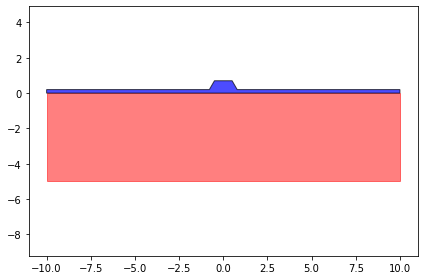

In [4]:
h_LN = 700*nm
h_etch = 500*nm
h_slab = h_LN - h_etch

width_top = 1*um

w_slab = 20*um
h_margin = 5*um
h_substrate = 5*um


theta = 60
wg_length = 10*um #Useless in MODE
width_top_base = width_top + 2*h_etch/np.tan(theta*pi/180)
w_sidewall = h_etch/np.tan(theta*pi/180)

print('slab = %.3f um' %(h_slab/um))
print('width at the base = %.3f um' %(width_top_base/um))

#Draw it
fig,ax = plt.subplots()
substrate = patches.Rectangle((-w_slab/2/um,-h_substrate/um), w_slab/um, h_substrate/um,
                             linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [w_slab/2,h_slab], [w_slab/2,0], 
                   [-w_slab/2,0], [-w_slab/2, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(substrate)
ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

## Parametric sweep

In [5]:
h_LN = 700*nm
freq = np.arange(100, 751, 20)*THz
width = np.arange(700, 1400, 100)*nm
etch = np.arange(200, 600, 100)*nm

Nsims = freq.size * width.size * etch.size
print('Number of sims needed = %i' %(Nsims))
print(Nsims*2/60)

Number of sims needed = 924
30.8


In [6]:
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))

In [7]:
nmodes = 6 #will save first 6 modes only

neff = np.zeros((freq.size, width.size, etch.size, nmodes))
ng = np.zeros((freq.size, width.size, etch.size, nmodes))
loss = np.zeros((freq.size, width.size, etch.size, nmodes))
te = np.zeros((freq.size, width.size, etch.size, nmodes))

tic_total = time.time()
Ndone = 0
for ke in range(etch.size):
    for kw in range(width.size):
        for kf in range(freq.size):
            tic = time.time()
            MODE.switchtolayout()

            h_etch = etch[ke]
            width_top = width[kw]
            f = freq[kf]
            wavelength = c/f
             
            meshsize = wavelength/10
            finemesh = wavelength/50
                
            #Draw waveguide and solver
            lum.draw_wg(MODE, material_thinfilm, material_substrate,
                          h_LN, h_substrate, h_etch, width_top, w_slab, theta, wg_length)
            lum.add_fine_mesh(MODE, finemesh, h_LN, width_top_base, x_factor=1.2, y_factor=1.5)
            lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                                     w_slab, wg_length, h_margin)

            _neff, _ng, _loss, _te = lum.solve_mode(MODE, wavelength, nmodes=20)

            neff[kf, kw, ke, :] = pad(_neff, nmodes)
            ng[kf, kw, ke, :] = pad(_ng, nmodes)
            loss[kf, kw, ke, :]  = pad(_loss, nmodes)
            te[kf, kw, ke, :]  = pad(_te, nmodes)
            
            Ndone += 1
            t_sim = time.time() - tic
            print('Completed %0.1f %% (time last sim = %0.1f m)' %(Ndone/Nsims*100, t_sim/60))

timestamp = str(round(time.time()))
data_filename = 'Data\LNOI_%inm_geom_sweep_' %(int(h_LN/nm))
data_filename = data_filename.replace('.','p')
data_filename += timestamp
np.savez(data_filename, freq=freq, width=width, etch=etch,
         neff=neff, tepf=te, loss=loss, ng=ng, #Main results
         h_LN=h_LN, theta=theta, h_substrate=h_substrate, w_slab=w_slab, h_margin=h_margin, 
         meshsize=meshsize, finemesh=finemesh, 
         material_substrate=material_substrate, material_thinfilm=material_thinfilm) 
            
    
MODE.close()
t_elapsed = time.time() - tic_total
print('Total time = %.1f  hr' %(t_elapsed/3600) )

Completed 0.1 % (time last sim = 1.0 m)
Completed 0.2 % (time last sim = 1.3 m)
Completed 0.3 % (time last sim = 1.1 m)
Completed 0.4 % (time last sim = 1.0 m)
Completed 0.5 % (time last sim = 0.5 m)
Completed 0.6 % (time last sim = 0.3 m)
Completed 0.8 % (time last sim = 1.3 m)
Completed 0.9 % (time last sim = 1.0 m)
Completed 1.0 % (time last sim = 2.2 m)
Completed 1.1 % (time last sim = 2.2 m)
Completed 1.2 % (time last sim = 1.6 m)
Completed 1.3 % (time last sim = 2.6 m)
Completed 1.4 % (time last sim = 1.7 m)
Completed 1.5 % (time last sim = 1.2 m)
Completed 1.6 % (time last sim = 1.2 m)
Completed 1.7 % (time last sim = 1.3 m)
Completed 1.8 % (time last sim = 1.6 m)
Completed 1.9 % (time last sim = 1.1 m)
Completed 2.1 % (time last sim = 1.6 m)
Completed 2.2 % (time last sim = 1.4 m)
Completed 2.3 % (time last sim = 1.6 m)
Completed 2.4 % (time last sim = 1.7 m)
Completed 2.5 % (time last sim = 1.7 m)
Completed 2.6 % (time last sim = 1.7 m)
Completed 2.7 % (time last sim = 1.8 m)


Completed 22.1 % (time last sim = 1.3 m)
Completed 22.2 % (time last sim = 1.6 m)
Completed 22.3 % (time last sim = 1.9 m)
Completed 22.4 % (time last sim = 0.4 m)
Completed 22.5 % (time last sim = 1.2 m)
Completed 22.6 % (time last sim = 1.1 m)
Completed 22.7 % (time last sim = 2.1 m)
Completed 22.8 % (time last sim = 0.5 m)
Completed 22.9 % (time last sim = 1.3 m)
Completed 23.1 % (time last sim = 1.3 m)
Completed 23.2 % (time last sim = 1.5 m)
Completed 23.3 % (time last sim = 1.7 m)
Completed 23.4 % (time last sim = 1.4 m)
Completed 23.5 % (time last sim = 1.1 m)
Completed 23.6 % (time last sim = 1.3 m)
Completed 23.7 % (time last sim = 1.4 m)
Completed 23.8 % (time last sim = 2.0 m)
Completed 23.9 % (time last sim = 1.8 m)
Completed 24.0 % (time last sim = 1.7 m)
Completed 24.1 % (time last sim = 1.7 m)
Completed 24.2 % (time last sim = 1.9 m)
Completed 24.4 % (time last sim = 2.2 m)
Completed 24.5 % (time last sim = 2.4 m)
Completed 24.6 % (time last sim = 2.4 m)
Completed 24.7 %

Completed 43.7 % (time last sim = 0.8 m)
Completed 43.8 % (time last sim = 0.9 m)
Completed 43.9 % (time last sim = 0.9 m)
Completed 44.0 % (time last sim = 0.4 m)
Completed 44.2 % (time last sim = 0.7 m)
Completed 44.3 % (time last sim = 1.7 m)
Completed 44.4 % (time last sim = 1.6 m)
Completed 44.5 % (time last sim = 1.5 m)
Completed 44.6 % (time last sim = 1.2 m)
Completed 44.7 % (time last sim = 0.7 m)
Completed 44.8 % (time last sim = 1.0 m)
Completed 44.9 % (time last sim = 0.7 m)
Completed 45.0 % (time last sim = 1.1 m)
Completed 45.1 % (time last sim = 1.3 m)
Completed 45.2 % (time last sim = 1.3 m)
Completed 45.3 % (time last sim = 1.1 m)
Completed 45.5 % (time last sim = 1.2 m)
Completed 45.6 % (time last sim = 1.6 m)
Completed 45.7 % (time last sim = 1.7 m)
Completed 45.8 % (time last sim = 1.7 m)
Completed 45.9 % (time last sim = 1.9 m)
Completed 46.0 % (time last sim = 1.7 m)
Completed 46.1 % (time last sim = 1.7 m)
Completed 46.2 % (time last sim = 2.1 m)
Completed 46.3 %

Completed 65.4 % (time last sim = 0.7 m)
Completed 65.5 % (time last sim = 1.2 m)
Completed 65.6 % (time last sim = 0.5 m)
Completed 65.7 % (time last sim = 0.7 m)
Completed 65.8 % (time last sim = 2.1 m)
Completed 65.9 % (time last sim = 2.1 m)
Completed 66.0 % (time last sim = 1.9 m)
Completed 66.1 % (time last sim = 1.9 m)
Completed 66.2 % (time last sim = 2.1 m)
Completed 66.3 % (time last sim = 1.0 m)
Completed 66.5 % (time last sim = 1.2 m)
Completed 66.6 % (time last sim = 2.2 m)
Completed 66.7 % (time last sim = 1.2 m)
Completed 66.8 % (time last sim = 2.0 m)
Completed 66.9 % (time last sim = 1.2 m)
Completed 67.0 % (time last sim = 2.0 m)
Completed 67.1 % (time last sim = 1.8 m)
Completed 67.2 % (time last sim = 2.3 m)
Completed 67.3 % (time last sim = 2.2 m)
Completed 67.4 % (time last sim = 2.6 m)
Completed 67.5 % (time last sim = 3.6 m)
Completed 67.6 % (time last sim = 3.1 m)
Completed 67.7 % (time last sim = 3.1 m)
Completed 67.9 % (time last sim = 3.2 m)
Completed 68.0 %

Completed 87.0 % (time last sim = 0.4 m)
Completed 87.1 % (time last sim = 0.4 m)
Completed 87.2 % (time last sim = 0.5 m)
Completed 87.3 % (time last sim = 0.5 m)
Completed 87.4 % (time last sim = 0.6 m)
Completed 87.6 % (time last sim = 0.6 m)
Completed 87.7 % (time last sim = 0.7 m)
Completed 87.8 % (time last sim = 0.8 m)
Completed 87.9 % (time last sim = 0.9 m)
Completed 88.0 % (time last sim = 1.0 m)
Completed 88.1 % (time last sim = 1.1 m)
Completed 88.2 % (time last sim = 1.2 m)
Completed 88.3 % (time last sim = 1.4 m)
Completed 88.4 % (time last sim = 1.7 m)
Completed 88.5 % (time last sim = 2.2 m)
Completed 88.6 % (time last sim = 1.5 m)
Completed 88.7 % (time last sim = 1.3 m)
Completed 88.9 % (time last sim = 1.4 m)
Completed 89.0 % (time last sim = 2.0 m)
Completed 89.1 % (time last sim = 2.1 m)
Completed 89.2 % (time last sim = 2.2 m)
Completed 89.3 % (time last sim = 2.4 m)
Completed 89.4 % (time last sim = 0.1 m)
Completed 89.5 % (time last sim = 0.1 m)
Completed 89.6 %